### Goal of this project: 
Given a global news, we are challenged to discover  
the topics that occur in a collections of articles . 

### Setup

Data manipulation libraries:

In [1]:
import pandas as pd
import numpy  as np
import spacy
import re

In [2]:
from sklearn.feature_extraction.text  import CountVectorizer , TfidfVectorizer
from sklearn.metrics.pairwise         import cosine_similarity

In [3]:
from sklearn.decomposition            import PCA
from sklearn.decomposition            import TruncatedSVD
from sklearn.cluster                  import KMeans

In [72]:
from   matplotlib        import pyplot as plt
import matplotlib.colors               as mcolors
import seaborn                         as sns

Classes instances

In [4]:
cv         = CountVectorizer(stop_words='english', max_df=3)
cv_tfidf   = TfidfVectorizer(stop_words='english', max_df=3)

In [5]:
pca = PCA(n_components=4)
lsa = TruncatedSVD(n_components=4)

### Dataset

In [6]:
file_path = '/Users/macbookproretina13inch/Desktop/GNF/Data/English_Global_news.csv'

Global_News = pd.read_csv(file_path,index_col=0 )

In [7]:
Global_News.index = pd.RangeIndex(start=0, stop=len(Global_News), step=1)

In [8]:
Global_News.head(2)

,Text,Text_lemma
0,details facebooks global partner summit,detail facebooks global partner summit
1,petrol diesel rise post daily price revisions ...,petrol diesel rise post daily price revisions ...


#### Taking a sample to avoid high processing cost

In [9]:
Global_News_spl  = Global_News[:15000]

In [10]:
Global_News_spl.shape

(15000, 2)

### Document Similarity Approachs

### Spacy

In [11]:
nlp = spacy.load('en_core_web_sm')

In [12]:
Global_News_spl['spacy_doc'] = Global_News_spl['Text'].astype(str).apply(nlp)

<ipython-input-12-e8395a24657e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Global_News_spl['spacy_doc'] = Global_News_spl['Text'].astype(str).apply(nlp)


In [13]:
Global_News_spl.head(2)

,Text,Text_lemma,spacy_doc
0,details facebooks global partner summit,detail facebooks global partner summit,"(details, facebooks, global, partner, summit)"
1,petrol diesel rise post daily price revisions ...,petrol diesel rise post daily price revisions ...,"(petrol, diesel, rise, post, daily, price, rev..."


In [ ]:
#Add some columns

In [115]:
lemma  = []
for doc in nlp.pipe(Global_News_spl['Text'].astype('unicode').values, batch_size=50,
                       ):
    if doc.is_parsed:
        lemma.append([n.lemma_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        lemma.append(None)
        
Global_News_spl['species_lemma']  = lemma

<ipython-input-115-5eba0f8e5106>:4: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if doc.is_parsed:
<ipython-input-115-5eba0f8e5106>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Global_News_spl['species_lemma']  = lemma


In [116]:
Global_News_spl.head(2)

,Text,Text_lemma,spacy_doc,species_lemma,Topic
0,details facebooks global partner summit,detail facebooks global partner summit,"(details, facebooks, global, partner, summit)","[detail, facebook, global, partner, summit]",Humanities
1,petrol diesel rise post daily price revisions ...,petrol diesel rise post daily price revisions ...,"(petrol, diesel, rise, post, daily, price, rev...","[petrol, diesel, rise, post, daily, price, rev...",Political


In [16]:
def get_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text) 
    return text

In [17]:
Global_News_spl['species_lemma'] = Global_News_spl['species_lemma'].astype(str).apply(get_text)

<ipython-input-17-2b96efacaf7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Global_News_spl['species_lemma'] = Global_News_spl['species_lemma'].astype(str).apply(get_text)


In [18]:
Global_News_spl.head(2)

,Text,Text_lemma,spacy_doc,species_lemma
0,details facebooks global partner summit,detail facebooks global partner summit,"(details, facebooks, global, partner, summit)",detail facebook global partner s...
1,petrol diesel rise post daily price revisions ...,petrol diesel rise post daily price revisions ...,"(petrol, diesel, rise, post, daily, price, rev...",petrol diesel rise post daily ...


# 

### CountVectorizer

In [19]:
X     =  Global_News_spl.species_lemma
X_cv  =  cv.fit_transform(X)

In [20]:
Document_TM = pd.DataFrame(X_cv.toarray(),columns=cv.get_feature_names())

In [21]:
Document_TM.head(2)

,aa,aaa,aaco,aadhaar,aafias,aais,aamc,aampw,aapl,aarey,...,zookeepers,zoom,zoos,zosano,zuma,zumas,zwave,zweig,zyme,zzen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Check cosine similarity

In [22]:
cosine_similarity(Document_TM)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 

### TF-IDF

In [23]:
X_tfidf = cv_tfidf.fit_transform(X).toarray()

In [24]:
TF_IDF  = pd.DataFrame(X_tfidf, columns = cv_tfidf.get_feature_names())

In [25]:
TF_IDF.head(2)

,aa,aaa,aaco,aadhaar,aafias,aais,aamc,aampw,aapl,aarey,...,zookeepers,zoom,zoos,zosano,zuma,zumas,zwave,zweig,zyme,zzen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Check cosine similarity  

In [26]:
cosine_similarity(TF_IDF)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

###  Topic Modeling  Functions

In [27]:
#  over DataFrame
def show_topics(vectorizer, model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [28]:
# over Text
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# 

###  Dimension Reduction Algorithm

#### PCA-DTM

In [29]:
# Document_TM
Pca_dtm   = pca.fit_transform(Document_TM)

In [30]:
Pca_dtm_comp = pca.components_ 

In [31]:
Pca_dtm_comp

array([[-2.79561371e-05, -1.46820680e-04, -1.28845553e-05, ...,
         3.16372247e-05, -1.34798693e-05, -1.38401747e-05],
       [-4.15348026e-05, -1.65718537e-05, -1.92984468e-05, ...,
        -3.17744702e-04, -2.01099019e-05, -2.14172359e-05],
       [-2.57167657e-05,  2.68371167e-03, -1.18585802e-05, ...,
        -2.11363096e-05, -1.26473583e-05, -1.30843844e-05],
       [-5.30304195e-05,  2.79592156e-04, -2.37600184e-05, ...,
         4.17057998e-04, -2.61312875e-05, -2.62352666e-05]])

In [32]:
print(pca.explained_variance_)

[0.00113263 0.00108431 0.00100181 0.00096942]


In [33]:
pca_ver = pca.explained_variance_

In [34]:
display_topics(pca, cv.get_feature_names(),10)


Topic  0
eregli, fabrikalari, ostim, jant, merkez, demir, celik, sodsn, kurulu, kayit

Topic  1
courthouse, reese, outrage, multnomah, mtn, marg, airlines, brussels, firecloudofgod, ch

Topic  2
milli, centraloregon, significant, overnight, marg, tulsa, sgt, humid, locked, antiperspirant

Topic  3
marg, madhya, greenpeace, dakshin, himalaya, denotify, chandigarh, ta, statute, racketeering


#### PCA_TFIDF

In [41]:
# TF_IDF
Pca_tf = pca.fit_transform(TF_IDF)

In [42]:
Pca_tf_comp = pca.components_ 

In [43]:
print(pca.explained_variance_)

[0.00019432 0.00019352 0.00019309 0.00019267]


In [44]:
display_topics(pca, cv_tfidf.get_feature_names(),10)


Topic  0
partygoer, exsheriff, driverless, wichita, dmx, preache, bros, warner, bajwa, payperview

Topic  1
hurdle, suffocate, payperview, preache, execution, smartwatch, lockn, biological, dodgy, speedy

Topic  2
nondisclosure, dmx, preregister, exsheriff, teslas, hitter, immunization, lara, preache, mcgregormayweather

Topic  3
flaw, daredevil, netherland, speedy, hitter, meis, nan, immunization, grope, mcgregormayweather


### Topic Modling 

####  LSA -DTM

In [45]:
# Document_TM
lsa_dtm = lsa.fit_transform(Document_TM)

In [46]:
lsa_dtm_comp = lsa.components_ 
lsa_dtm_comp

array([[-1.85774717e-05, -1.01200933e-03,  1.69989509e-06, ...,
        -2.14775569e-04, -2.59020822e-05,  1.66562135e-05],
       [ 1.88704606e-05,  2.91582128e-03,  4.45749161e-07, ...,
         6.23706224e-04,  1.50731325e-06, -1.94261468e-05],
       [-1.34908472e-05,  1.78746377e-03,  2.63166592e-06, ...,
        -9.11548880e-05, -5.72678424e-06, -4.16586544e-05],
       [-5.27460907e-05, -5.94240929e-03,  2.04373346e-06, ...,
         2.83525273e-04,  6.88273452e-06,  8.24245455e-07]])

In [47]:
lsa.explained_variance_ratio_

array([0.00080013, 0.00076006, 0.00068592, 0.00067975])

In [48]:
topic_keywords = show_topics(vectorizer=cv, model=lsa, n_words=10)        

In [49]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index   = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.T

,Topic 0,Topic 1,Topic 2,Topic 3
Word 0,ayes,courthouse,milli,marg
Word 1,umpas,reese,centraloregon,madhya
Word 2,eregl,outrage,overnight,himalaya
Word 3,eregli,multnomah,significant,dakshin
Word 4,kurulu,ni,greenpeace,chandigarh
Word 5,raysg,ng,apui,denotify
Word 6,celik,mga,ta,milli
Word 7,unyec,padilla,ch,centraloregon
Word 8,demir,khanna,empirical,overnight
Word 9,ittfh,daria,mtn,significant


In [50]:
display_topics(lsa, cv.get_feature_names(),10)


Topic  0
ayes, umpas, eregli, ostim, kayit, merkez, akbnk, sodsn, raysg, kurulu

Topic  1
courthouse, reese, outrage, multnomah, ni, ng, mga, padilla, daria, momaya

Topic  2
milli, centraloregon, overnight, significant, greenpeace, apui, ta, ch, empirical, mtn

Topic  3
marg, madhya, chandigarh, himalaya, dakshin, denotify, milli, centraloregon, overnight, significant


####  LSA- TFIDF

In [51]:
# TF_IDF
lsa_tf = lsa.fit_transform(TF_IDF)

In [52]:
lsa_tf_comp = lsa.components_ 
lsa_tf_comp

array([[ 4.81754001e-04, -1.82792491e-04,  1.15614502e-04, ...,
         7.89694470e-05, -1.73660789e-05, -7.72237296e-05],
       [-1.38228555e-03, -8.52242990e-05,  6.93039718e-05, ...,
         1.66387624e-04,  7.57684660e-05,  4.43563076e-05],
       [ 5.51476125e-04,  3.30167651e-04, -7.54299175e-05, ...,
         3.10073311e-04, -6.25144531e-05, -5.00528572e-05],
       [ 1.04938629e-04, -2.50567687e-03,  1.77761608e-04, ...,
         3.71140735e-05, -1.30166816e-04,  8.01232423e-05]])

In [53]:
lsa.explained_variance_ratio_

array([0.00026801, 0.00026667, 0.00026451, 0.00026428])

In [54]:
topic_keywords = show_topics(vectorizer=cv_tfidf, model=lsa, n_words=10)        

In [55]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.T

,Topic 0,Topic 1,Topic 2,Topic 3
Word 0,exfbi,nondisclosure,execution,milos
Word 1,pawtucket,petersburg,surplus,bajwa
Word 2,dmx,payperview,gastro,lara
Word 3,thirty,erasmus,aloha,population
Word 4,biological,munster,lockn,airfare
Word 5,nondisclosure,tribune,chipotle,smartwatch
Word 6,largely,pga,tinder,magnifymoney
Word 7,tribune,backpage,soulsearche,carjacking
Word 8,execution,mcgregormayweather,petersburg,swap
Word 9,remains,outreach,yard,catalonia


In [56]:
display_topics(lsa, cv_tfidf.get_feature_names(),10)


Topic  0
exfbi, pawtucket, dmx, thirty, biological, nondisclosure, largely, tribune, execution, remains

Topic  1
nondisclosure, petersburg, payperview, erasmus, munster, tribune, pga, backpage, mcgregormayweather, outreach

Topic  2
execution, surplus, gastro, aloha, lockn, chipotle, tinder, soulsearche, petersburg, yard

Topic  3
milos, bajwa, lara, population, airfare, smartwatch, magnifymoney, carjacking, swap, catalonia


### Clustring with Kmean

- KMean

In [57]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++',random_state=60, max_iter=100, n_init=1)
model.fit(Pca_tf_comp) # Algorithem

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind]),

Top terms per cluster:
Cluster 0:
 hurdle
 suffocate
 payperview
 preache
 execution
 smartwatch
 lockn
 biological
 dodgy
 speedy
 peek
 catalonia
 gastro
 grope
 netherland
 petersburg
 halfstaff
 soulsearche
 autistic
 remains
Cluster 1:
 flaw
 daredevil
 netherland
 speedy
 hitter
 meis
 nan
 immunization
 grope
 mcgregormayweather
 teslas
 bajwa
 ultrasound
 gamechanger
 pawtucket
 tinder
 carjacking
 execution
 widow
 meltdown
Cluster 2:
 nondisclosure
 dmx
 preregister
 exsheriff
 teslas
 hitter
 immunization
 lara
 preache
 mcgregormayweather
 alba
 angola
 gastro
 soulsearche
 netherland
 houthi
 exfbi
 population
 pawtucket
 remains
Cluster 3:
 partygoer
 exsheriff
 driverless
 wichita
 dmx
 preache
 bros
 warner
 bajwa
 payperview
 thirty
 flaw
 gastro
 nan
 grope
 houthi
 blacklist
 superbug
 peek
 pace


Results
We can notice that topics are:

Topic 0: Humanities  
Topic 1: Cases and Accidents     
Topic 2: Culture and Society  
Topic 3: Political   

In [62]:
prediction = model.predict(TF_IDF)
prediction

array([0, 3, 2, ..., 0, 1, 0], dtype=int32)

In [63]:
Global_News_spl['Topic'] = prediction
Global_News_spl.Topic.replace({0: "Humanities ", 1: "Cases and Accidents", 2:"Culture and Society", 3:"Political"}, inplace=True)
Global_News_spl.sample(10)

<ipython-input-63-d4e094db96fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Global_News_spl['Topic'] = prediction
/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Text,Text_lemma,spacy_doc,species_lemma,Topic
14647,smsp volunteers hawaiian humane society image,smsp volunteer hawaiian humane society image,"(smsp, volunteers, hawaiian, humane, society, ...",smsp volunteer hawaiian humane s...,Humanities
4051,comment charlottesville white color steve,comment charlottesville white color steve,"(comment, charlottesville, white, color, steve)",comment charlottesville white color...,Humanities
793,coach kirk ferentz donates million iowa hospital,coach kirk ferentz donate million iowa hospital,"(coach, kirk, ferentz, donates, million, iowa,...",coach kirk ferentz donate millio...,Humanities
6523,detroiter says suburban cops terrorized raid,detroiter say suburban cop terrorize raid,"(detroiter, says, suburban, cops, terrorized, ...",detroiter say suburban cop terro...,Humanities
3071,chanel iman makes model football player boyfri...,chanel iman make model football player boyfrie...,"(chanel, iman, makes, model, football, player,...",chanel iman make model football ...,Cases and Accidents
12673,dr andrew jones director geoscience energy mar...,dr andrew jones director geoscience energy mar...,"(dr, andrew, jones, director, geoscience, ener...",dr andrew jones director geoscie...,Humanities
1490,cities lose altweekly dies,cities lose altweekly die,"(cities, lose, altweekly, dies)",city lose altweekly die,Political
2994,ghs seniors take art skills pavement,ghs seniors take art skills pavement,"(ghs, seniors, take, art, skills, pavement)",ghs senior take art skill pav...,Political
14170,yearold killed forest fire mankayane,yearold kill forest fire mankayane,"( , yearold, killed, forest, fire, mankayane)",yearold kill forest fire ma...,Culture and Society
3654,exwsj reporters upset former editor demands fa...,exwsj reporters upset former editor demand fac...,"(exwsj, reporters, upset, former, editor, dema...",exwsj reporter upset former edit...,Political


In [64]:
Global_News_spl.Topic.value_counts()

Humanities             6200
Political              4256
Culture and Society    3132
Cases and Accidents    1412
Name: Topic, dtype: int64

In [65]:
Vt = pd.DataFrame(lsa_tf.round(3),
             index = Global_News_spl,
             columns = ['Humanities','Cases and Accidents','Culture and Society','Political'])
Vt.head(10)

,Humanities,Cases and Accidents,Culture and Society,Political
"(details facebooks global partner summit, detail facebooks global partner summit , (details, facebooks, global, partner, summit), detail facebook global partner summit , Humanities )",0.000,0.000,0.000,0.000
"(petrol diesel rise post daily price revisions economic times, petrol diesel rise post daily price revisions economic time , (petrol, diesel, rise, post, daily, price, revisions, economic, times), petrol diesel rise post daily price revision economic time , Political)",0.004,-0.000,-0.001,0.000
"(comment microsoft never sneakily force windows downloads users michael weyant, comment microsoft never sneakily force windows download users michael weyant , (comment, microsoft, never, sneakily, force, windows, downloads, users, michael, weyant), comment microsoft never sneakily force window download user michael weyant , Culture and Society)",0.000,0.000,-0.000,0.000
"(comment google chrome enterprise techfan, comment google chrome enterprise techfan , (comment, google, chrome, enterprise, techfan), comment google chrome enterprise techfan , Culture and Society)",0.000,0.000,-0.000,-0.000
"(new uncharted best spend gaming , new uncharted best spend game , (new, uncharted, best, spend, gaming), new uncharted good spend gaming , Cases and Accidents)",0.004,0.008,-0.002,0.006
"(espn robert lee right, espn robert lee right , (espn, robert, lee, right), espn robert lee right , Humanities )",0.000,0.000,0.000,0.000
"(louise lintons famous post instagrams celebrity problem, louise lintons famous post instagrams celebrity problem , (louise, lintons, famous, post, instagrams, celebrity, problem), louise linton famous post instagram celebrity problem , Humanities )",0.000,0.000,0.000,0.000
"(broomfield council sets oil gas ballot item could codify health safety charter, broomfield council set oil gas ballot item could codify health safety charter , (broomfield, council, sets, oil, gas, ballot, item, could, codify, health, safety, charter), broomfield council set oil gas ballot item could codify health safety charter , Culture and Society)",0.003,0.001,0.003,-0.002
"(fec meeting must held every week presidency, fec meet must hold every week presidency , (fec, meeting, must, held, every, week, presidency), fec meeting must hold every week presidency , Political)",0.000,0.001,0.000,0.001
"(fake importers smuggle billion algiers port, fake importers smuggle billion algiers port , (fake, importers, smuggle, billion, algiers, port), fake importer smuggle billion algier port , Political)",-0.000,-0.000,0.000,0.000


### Topics visualization

In [66]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()
            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')
        

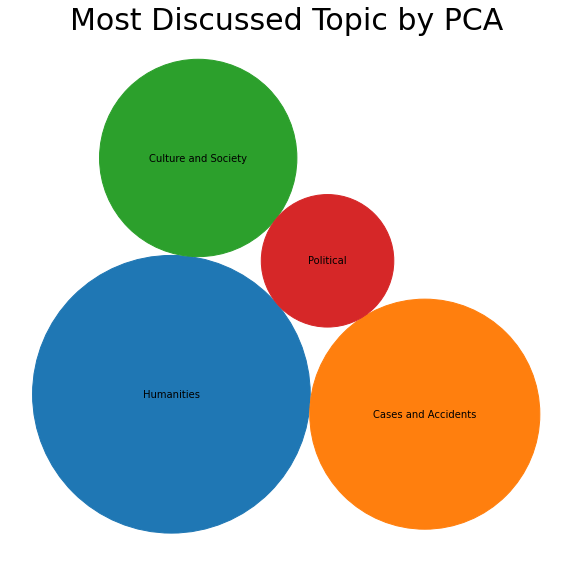

In [69]:
color = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topics_bubbles = ['Humanities','Cases and Accidents','Culture and Society','Political']

values = list(Global_News_spl.Topic.value_counts().values)

bubble_chart = BubbleChart(area=values,
                           bubble_spacing=0.1)
bubble_chart.collapse()

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, topics_bubbles, color)
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Most Discussed Topic by PCA', fontsize=30)
plt.savefig("Topic_PCA.png")

plt.show()

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


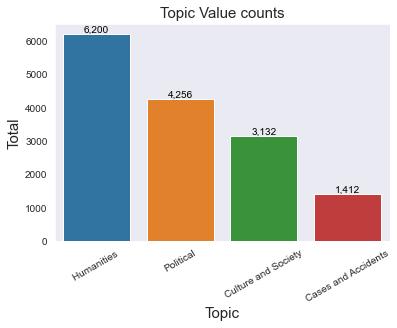

In [113]:
x=Global_News_spl.Topic.value_counts()
ax = sns.barplot(x.index,x)

for i, v in enumerate(x.iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), ha='center', va ='bottom', fontsize=10, color='black', rotation=0)
    
plt.title("Topic Value counts",size='15')
plt.xlabel("Topic",size='15')
plt.ylabel("Total",size='15')
plt.xticks(rotation=30)
plt.savefig("Topic_freq.png")
plt.gca();